### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model

from sklearn.utils.class_weight import compute_class_weight

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt

from datetime import datetime

import pickle

from PIL import Image

from balanced_accuracy_class import BalancedAccuracy

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

pd.__version__: 2.2.3
tf.__version__: 2.17.1


### Read file path and labels to list

In [2]:
dataset_dir = "/kaggle/working/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

display(csv_df)

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

,angle,speed
image_id,,
1,0.4375,0.0
2,0.8125,1.0
3,0.4375,1.0
4,0.6250,1.0
5,0.5000,0.0
...,...,...
13794,0.6250,1.0
13795,0.4375,1.0
13796,0.5625,0.0


Check the data

(array([  88.,  197.,  104.,  641., 1467., 3655., 3970., 2123., 1448.,
         100.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

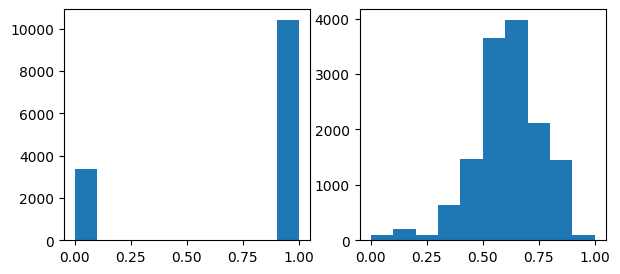

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].hist(csv_df["speed"])
ax[1].hist(csv_df["angle"])

In [4]:
list_ds = tf.data.Dataset.list_files(
    os.path.join(training_data_dir, "*"), shuffle=False
)
image_count = len(list_ds)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False, seed=24)

for f in list_ds.take(5):
    print(f.numpy())

b'/kaggle/working/Dataset/machine-learning-in-science-ii-2025/training_data/training_data/9608.png'
b'/kaggle/working/Dataset/machine-learning-in-science-ii-2025/training_data/training_data/11549.png'
b'/kaggle/working/Dataset/machine-learning-in-science-ii-2025/training_data/training_data/8194.png'
b'/kaggle/working/Dataset/machine-learning-in-science-ii-2025/training_data/training_data/5057.png'
b'/kaggle/working/Dataset/machine-learning-in-science-ii-2025/training_data/training_data/3391.png'


### Get Labels

In [5]:
image_id_list = csv_df.index.to_list()
angle_list = csv_df["angle"].to_list()
speed_list = csv_df["speed"].to_list()

# As we want to do these things in tensor operation

# Convert to tf objects
image_id_tensor = tf.constant(image_id_list)
angle_tensor = tf.constant(angle_list)
speed_tensor = tf.constant(speed_list)

# Create lookup tables
angle_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(image_id_tensor, angle_tensor),
    default_value=-1.0,
)

speed_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(image_id_tensor, speed_tensor),
    default_value=-1.0,
)

In [6]:
def get_label(file_path):
    # Convert the path to a list of path components
    file_name = tf.strings.split(file_path, os.path.sep)
    id_str = tf.strings.split(file_name[-1], ".")[0]
    id = tf.strings.to_number(id_str, out_type=tf.int32)

    angle, speed = angle_table[id], speed_table[id]

    return angle, speed

In [7]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

In [8]:
def process_path(file_path):
    angle, speed = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, (angle, speed)

### Split into training and test set

In [9]:
val_size = int(image_count * 0.15)
test_size = int(image_count * 0.15)

val_ds = list_ds.take(val_size)
train_ds = list_ds.skip(val_size)

test_ds = train_ds.take(test_size)
train_ds = train_ds.skip(test_size)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

9660
2069
2069


In [10]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

# Skip corrupted images
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds.apply(tf.data.experimental.ignore_errors())
test_ds = test_ds.apply(tf.data.experimental.ignore_errors())

In [11]:
for image, (angle, speed) in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label (angle, speed): %.3f, %.3f" % (angle.numpy(), speed.numpy()))

Image shape:  (240, 320, 3)
Label (angle, speed): 0.812, 0.000


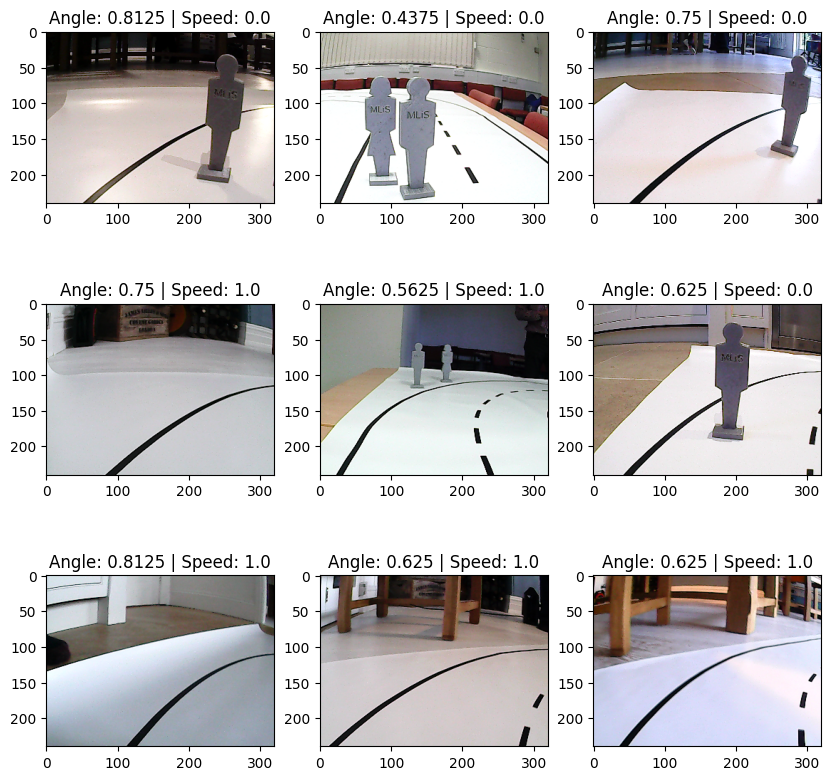

In [12]:
plt.figure(figsize=(10, 10))
i = 0

for image, (angle, speed) in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    angle = angle.numpy()
    speed = speed.numpy()
    plt.title(f"Angle: {angle} | Speed: {speed}")
    i += 1

### Data preprocessing
#### Speed
Check ratio

In [13]:
def find_speed_1_percentage(ds):
    count_speed_0 = 0
    count_speed_1 = 0

    for image, (angle, speed) in ds:
        speed_value = speed.numpy()
        count_speed_0 += speed_value == 0
        count_speed_1 += speed_value == 1

    return count_speed_1 / (count_speed_0 + count_speed_1)

In [14]:
# print(f"train_ds: {find_speed_1_percentage(train_ds):.3f} are speed_1")
# print(f"val_ds: {find_speed_1_percentage(val_ds):.3f} are speed_1")
# print(f"test_ds: {find_speed_1_percentage(test_ds):.3f} are speed_1")

We found that around 75% of data has speed == 1. So maybe try class weighting later.

In [15]:
train_speed_list = []
for _, (_, speed) in train_ds:
    train_speed_list.append(speed.numpy())

#### Angle
As shown earlier, it is normally-ish distributed, but shifted. So lets try to standardise the data.
We will only just the train_ds for the stat (i.e. mean and std)

Easy way

In [16]:
angle_list = []
for _, (angle, _) in train_ds:
    angle_value = angle.numpy()
    angle_list.append(angle_value)

train_mean = np.mean(angle_list)
train_std = np.std(angle_list)

print(train_mean, train_std)

train_mean_tf = tf.constant(train_mean, tf.float32)
train_std_tf = tf.constant(train_std, tf.float32)

0.60732967 0.15438792


Fancy way

In [17]:
# train_angle_ds = train_ds.map(lambda image, (angle, speed): angle)


# def reduce_mean_func(state, value):
#     sum, count = state
#     return sum + value, count + 1


# angle_sum, angle_count = train_angle_ds.reduce(
#     (tf.constant(0.0, tf.float32), tf.constant(0, tf.int32)), reduce_mean_func
# )

# angle_mean = angle_sum / tf.cast(angle_count, tf.float32)

# def reduce_mean_sq_func(state, value):
#     return state + tf.square(value)


# angle_squared_sum = train_angle_ds.reduce(
#     tf.constant(0.0, tf.float32), reduce_mean_sq_func
# )

# angle_squared_mean = angle_squared_sum / tf.cast(angle_count, tf.float32)
# angle_var = angle_squared_mean - tf.square(angle_mean)
# angle_std = tf.sqrt(angle_var)

# print(angle_mean.numpy(),angle_std.numpy())

Standardise angle

In [18]:
def standardise_train_ds(image, label):
    angle, speed = label
    return image, ((angle - train_mean_tf) / train_std_tf, speed)


standardised_train_ds = train_ds.map(
    standardise_train_ds, num_parallel_calls=tf.data.AUTOTUNE
)

### Data augmentation

In [19]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

Test visualise function

In [20]:
# for image, angle, speed in train_ds.take(1):
#   for i in range(3):
#     seed = (np.random.randint(0, 2^20), np.random.randint(0, 2^20))
#     stateless_random_brightness = tf.image.stateless_random_brightness(
#       image, max_delta=0.3, seed=seed)
#     visualise(image, stateless_random_brightness)

In [21]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, label, seed=None):
    angle, speed = label
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, (angle, speed)

Test augment function

20


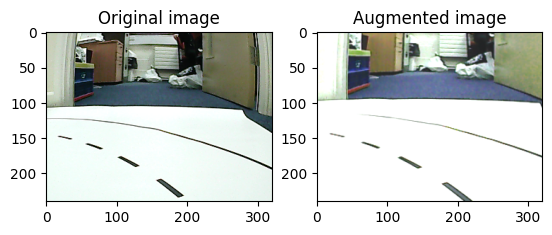

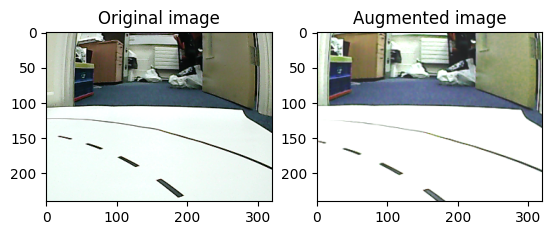

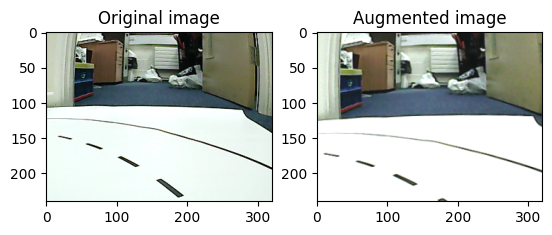

In [22]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, (angle, speed) in standardised_train_ds.skip(skip).take(1):
        augmented_image, (angle, speed) = augment(image, (angle, speed), None)
        visualise(image, augmented_image)

In [23]:
for image, (angle, speed) in standardised_train_ds.take(1):
    aug_image, (aug_angle, aug_speed) = augment(image, (angle, speed))
    print(f"Augmented image shape: {aug_image.shape}")

Augmented image shape: (240, 320, 3)


In [24]:
standardised_train_ds = train_ds.map(
    standardise_train_ds, num_parallel_calls=tf.data.AUTOTUNE
)
standardised_train_ds = standardised_train_ds.map(
    augment, num_parallel_calls=tf.data.AUTOTUNE
)

standardised_val_ds = train_ds.map(
    standardise_train_ds, num_parallel_calls=tf.data.AUTOTUNE
)
# standardised_val_ds = standardised_val_ds.map(
#     augment, num_parallel_calls=tf.data.AUTOTUNE
# )

### Optimise performance

In [25]:
def rephrase_ds(image, label):
    angle, speed = label
    return image, {"angle_output": angle, "speed_output": speed}


standardised_train_ds = standardised_train_ds.map(
    rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE
)
standardised_val_ds = standardised_val_ds.map(
    rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE
)

standardised_train_ds = standardised_train_ds.repeat()

In [26]:
batch_size = 32


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


standardised_train_ds = configure_for_performance(standardised_train_ds, shuffle=True, batch=True)
standardised_val_ds = configure_for_performance(standardised_val_ds, shuffle=False, batch=True)


### Build model

In [27]:
class_weight = compute_class_weight("balanced", classes=[0, 1], y=train_speed_list)
class_weight_dict = {0: class_weight[0], 1: class_weight[1]}
print(class_weight_dict)

{0: 2.031986531986532, 1: 0.6631868131868132}


In [28]:
def weighted_binary_crossentropy(y_true, y_pred):
    class_weight = tf.convert_to_tensor(
        [class_weight_dict[i] for i in sorted(class_weight_dict.keys())],
        dtype=tf.float32,
    )

    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip 0s and 1s
    
    bce = keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)

    weights = tf.gather(class_weight, tf.cast(y_true, tf.int32))

    return tf.reduce_mean(weights * bce_loss)

In [29]:
image_shape = (240, 320, 3)

base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    name="efficientnetv2-s",
)
base_model.trainable = False
# base_model.summary()

In [30]:
base_model.output

<KerasTensor shape=(None, 8, 10, 1280), dtype=float32, sparse=False, name=keras_tensor_512>

In [31]:
feature_extractor = base_model.output

# angle

# path 1
angle_global_features = layers.GlobalAveragePooling2D()(feature_extractor)
angle_global_features = layers.BatchNormalization()(angle_global_features) 
angle_global_features = layers.Dropout(0.2)(angle_global_features)

# path 2
angle_conv_features = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(feature_extractor)  
angle_conv_features = layers.BatchNormalization()(angle_conv_features)
angle_conv_features = layers.Flatten()(angle_conv_features)

# merge
angle_merged_features = layers.Concatenate()([angle_global_features, angle_conv_features])
angle_merged_features = layers.BatchNormalization()(angle_merged_features) 

angle_hidden_4 = layers.Dense(2560, activation="relu", kernel_initializer='he_uniform', name="angle_hidden_4")(angle_merged_features)
angle_hidden_4 = layers.Dropout(0.3)(angle_hidden_4)
angle_hidden_3 = layers.Dense(1024, activation="relu", kernel_initializer='he_uniform', name="angle_hidden_3")(angle_hidden_4)
angle_hidden_2 = layers.Dense(512, activation="relu", kernel_initializer='he_uniform', name="angle_hidden_2")(angle_hidden_3)
angle_hidden = layers.Dense(100, activation="relu", kernel_initializer='he_uniform', name="angle_hidden")(angle_hidden_2)
angle_output = layers.Dense(1, activation="linear", name="angle_output")(angle_hidden)


# speed

# path 1
speed_global_features = layers.GlobalAveragePooling2D()(feature_extractor)

# path 2
speed_conv_features = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_uniform", padding="same")(feature_extractor)
speed_conv_features = layers.BatchNormalization()(speed_conv_features) 
speed_conv_features = layers.Flatten()(speed_conv_features)

# merge
speed_merged_features = layers.Concatenate()([speed_global_features, speed_conv_features])
speed_merged_features = layers.BatchNormalization()(speed_merged_features) 

speed_hidden_2 = layers.Dense(1000, activation="relu", kernel_initializer="he_uniform", name="speed_hidden_2")(speed_global_features)
speed_hidden = layers.Dense(147, activation="relu", kernel_initializer="he_uniform", name="speed_hidden")(speed_hidden_2)
speed_output = layers.Dense(1, activation="sigmoid", name="speed_output")(speed_hidden)

model = Model(
    inputs=base_model.input, outputs=[angle_output, speed_output], name="my_model"
)

learning_rate = 0.007

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"angle_output": "mse", "speed_output": weighted_binary_crossentropy},
    metrics={"angle_output": "mae", "speed_output": ["accuracy", BalancedAccuracy()]},
)

# model.summary()

In [32]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=1000000, show_layer_names=True)

sub_model = Model(
    inputs=feature_extractor, outputs=[angle_output, speed_output], name="ensemble_head"
)

tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

Saved model image: model.png


In [33]:
# for batch in standardised_train_ds.take(1):
#     image, label = batch
#     print(label['angle_output'])
#     plt.imshow(image[0].numpy())
#     plt.title(f"Angle: {label['angle_output'][0].numpy()}, Speed: {label['speed_output'][1].numpy()}")
#     plt.show()

In [34]:
def lr_schedule(epoch, lr):
    initial_lr = learning_rate
    decay = 0.5
    return initial_lr / (1 + ((epoch + 2) // 4) * decay)

with open('learning_rate.txt', 'w') as file:
    for i in range(30):
        output = f'Epoch {i + 1:2d}: {lr_schedule(i, 1)}\n'  # Adjust initial_lr as needed
        file.write(output)  # Write to the file

print("Saved learning rate at each epoch: learning_rate.txt")

Saved learning rate at each epoch: learning_rate.txt


In [35]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/model_epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

history_callback = keras.callbacks.History()

try:
    history = model.fit(
        standardised_train_ds,
        validation_data=standardised_val_ds,
        epochs=30,
        steps_per_epoch = train_ds_length // batch_size,
        callbacks=[checkpoint, history_callback, lr_scheduler], 
        verbose=1,
    )
except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open('training_history.pkl', 'wb') as f:
        pickle.dump(history_callback.history, f)


Epoch 1: LearningRateScheduler setting learning rate to 0.007.
Epoch 1/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - angle_output_loss: 1888.6108 - angle_output_mae: 10.8124 - loss: 1889.2406 - speed_output_accuracy: 0.7437 - speed_output_balanced_accuracy: 0.5749 - speed_output_loss: 0.6297
Epoch 1: saving model to checkpoints/model_epoch_01.keras


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


301/301 ━━━━━━━━━━━━━━━━━━━━ 117s 222ms/step - angle_output_loss: 1883.5974 - angle_output_mae: 10.7865 - loss: 1884.2267 - speed_output_accuracy: 0.7439 - speed_output_balanced_accuracy: 0.5752 - speed_output_loss: 0.6292 - val_angle_output_loss: 0.6855 - val_angle_output_mae: 0.6265 - val_loss: 0.9808 - val_speed_output_accuracy: 0.8969 - val_speed_output_balanced_accuracy: 0.8051 - val_speed_output_loss: 0.2953 - learning_rate: 0.0070

Epoch 2: LearningRateScheduler setting learning rate to 0.007.
Epoch 2/30
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - angle_output_loss: 0.8950 - angle_output_mae: 0.6974 - loss: 1.2640 - speed_output_accuracy: 0.8502 - speed_output_balanced_accuracy: 0.7435 - speed_output_loss: 0.3690
Epoch 2: saving model to checkpoints/model_epoch_02.keras
301/301 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - angle_output_loss: 0.8948 - angle_output_mae: 0.6973 - loss: 1.2638 - speed_output_accuracy: 0.8502 - speed_output_balanced_accuracy: 0.7436 - speed_output_loss: 0.3

In [36]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'v2_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

['angle_output_loss', 'angle_output_mae', 'loss', 'speed_output_accuracy', 'speed_output_balanced_accuracy', 'speed_output_loss', 'val_angle_output_loss', 'val_angle_output_mae', 'val_loss', 'val_speed_output_accuracy', 'val_speed_output_balanced_accuracy', 'val_speed_output_loss']


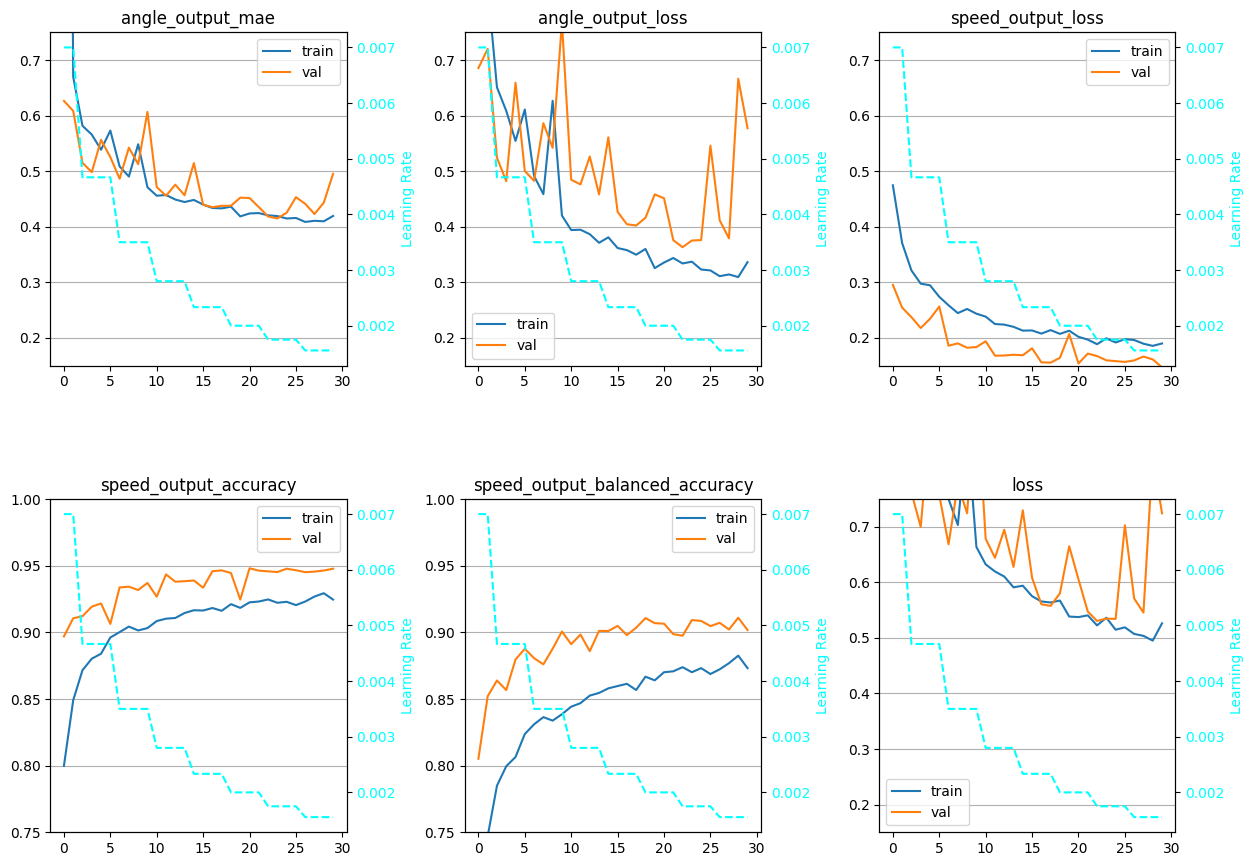

In [40]:
history = history_callback.history

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


ax = ax.ravel()

keys = list(history.keys())
print(keys)
needed = [1, 0, 5, 3, 4, 2]
groups = [keys[i] for i in needed]

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            label = "val" if key.startswith("val") else "train"
            ax[j].plot(history[key], label=label)
            ax[j].set_title(groups[j])
            ax[j].grid(True, axis="y")
            ax[j].legend()
            break

ylim_list = [
    (0.15, 0.75),
    (0.15, 0.75),
    (0.15, 0.75),
    (0.75, 1),
    (0.75, 1),
    (0.15, 0.75),
]
for i in range(len(groups)):
    lower, upper = ylim_list[i]
    ax[i].set_ylim(lower, upper)

learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")



# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])


plt.savefig(f"{folder_path}/{name_template}.png")

In [38]:
standardised_test_ds = test_ds.map(
    standardise_train_ds, num_parallel_calls=tf.data.AUTOTUNE
)

standardised_test_ds = configure_for_performance(standardised_test_ds, shuffle=False, batch=False)

result = model.predict(standardised_test_ds)

2069/2069 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step


In [39]:
i = 0
sq_error = []
for image, (angle, speed) in standardised_test_ds:
    sq_error.append((angle.numpy() - result[0][i]) **2)
    # print(angle.numpy(), speed.numpy())
    # print(result[0][i], result[1][i])
    # print()
    i+=1
print(np.mean(sq_error))

0.5317883
